In [1]:
from data import MLMDataset, load_wikitext2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random

### Loading Data

In [3]:
tokenized_data, vocab = load_wikitext2()

In [4]:
for id, data in enumerate(tokenized_data):
    if id < 5:
        print(id, len(data))

# Each sentence and the token length

0 5
1 127
2 91
3 101
4 5


In [6]:
# dataset_raw

In [7]:
# dataset_raw = load_dataset("wikitext", "wikitext-2-v1", split="train")
# text_data = dataset_raw['text']
# for line in text_data[:5]:
#     print(line)

In [5]:
%%time
# Loading dataset into torch dataset class
dataset = MLMDataset(tokenized_data, vocab)

CPU times: user 13 μs, sys: 3 μs, total: 16 μs
Wall time: 21.2 μs


In [6]:
# Dataloader class in torch
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
next(iter(dataloader))

[tensor([[   2,  138,  291,  ...,    0,    0,    0],
         [   2, 5827,    1,  ...,    0,    0,    0],
         [   2,  655, 3591,  ...,   86, 1113,   16],
         ...,
         [   2,    4,    1,  ...,    0,    0,    0],
         [   2,   86, 5636,  ...,    0,    0,    0],
         [   2,    1,    1,  ...,    0,    0,    0]]),
 tensor([[    2,  -100,  -100,  ...,     0,     0,     0],
         [    2,  -100,  2256,  ...,     0,     0,     0],
         [    2,  -100,  -100,  ...,  -100,  -100,  -100],
         ...,
         [    2,  -100,     4,  ...,     0,     0,     0],
         [    2,  -100,  -100,  ...,     0,     0,     0],
         [    2,  7405, 22000,  ...,     0,     0,     0]])]

In [8]:
len(dataloader)

1486

In [9]:
# Checking for certain vocabulary
check_list = ["man", "woman", "table","sit", "teacher", "rights", "human", "abuses", "sorrow", "fast", "loudly", "hospital"]

for word in check_list:
    try:
        word_id = vocab[word]
    except:
        word_id = None

    print(f"{word} - {word_id}")

man - 2321
woman - 456
table - 346
sit - 8100
teacher - 5914
rights - 2536
human - 2535
abuses - 2537
sorrow - None
fast - 6072
loudly - 20239
hospital - 4767


In [10]:
len(dataloader)

1486

### Model Instance Initialization

In [11]:
from model import GloVeTransformerMLM

import torch
from torch.optim import Adam

import numpy as np

In [12]:
def load_glove_embeddings(vocab, glove_path="glove.6B.300d.txt"):
    embedding_dim = 300
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embedding_dim))  # Random init
    found = 0
    
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype=np.float32)
            if word in vocab:
                embeddings[vocab[word]] = vector
                found += 1

    print(f"Loaded {found}/{len(vocab)} word vectors from GloVe.")
    return torch.tensor(embeddings, dtype=torch.float)

In [20]:
%%time
glove_embeddings = load_glove_embeddings(vocab, "/mnt/d/Acads/2025-Spring/AdvInformationProcessing/Project 1/glove.6B.300d.txt")

Loaded 19630/33281 word vectors from GloVe.
CPU times: user 1min 8s, sys: 3.05 s, total: 1min 11s
Wall time: 2min 9s


In [22]:
# Model instance
model_mlm = GloVeTransformerMLM(vocab_size=len(vocab), embed_dim=300,num_heads=6, hidden_dim=900, num_layers=3, glove_weights=glove_embeddings)

In [24]:
print(model_mlm)

GloVeTransformerMLM(
  (embedding): Embedding(33281, 300)
  (transformer_layers): Sequential(
    (0): TransformerLayer(
      (attention): MultiHeadSelfAttention(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
      )
      (ffn): FeedForwardNetwork(
        (fc1): Linear(in_features=300, out_features=900, bias=True)
        (fc2): Linear(in_features=900, out_features=300, bias=True)
        (activation): GELU(approximate='none')
        (norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (attention): MultiHeadSelfAttention(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
      )
      (ffn): FeedForwardNetwork(
        (fc1): Linear(in_features=300, out_fea

In [ ]:
# len(dataset_raw)

In [32]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlm = model_mlm.to(device)

In [33]:
device

device(type='cuda')

### Training Parameters

In [34]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import get_scheduler

In [35]:
# Define loss function (MLM loss ignores non-masked tokens)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)  

In [36]:
# Optimizer
optimizer = optim.AdamW(model_mlm.parameters(), lr=5e-3, weight_decay=0.01)

In [37]:
num_epochs = 20

In [38]:
num_training_steps = len(dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

### Validation Script

In [39]:
TRACK_WORDS = ['man','boy', 'woman', 'king','queen', 'rights', 'human','freedom', 'table', 'sit', 'tiger', 'carnivore']

In [40]:
def get_word_embeddings(model, vocab, tracked_words):
    """Fetch the embeddings of given words from the embedding layer."""
    model.eval()  # Ensure model is in evaluation mode to avoid training randomness
    embeddings = {}

    with torch.no_grad():
        for word in tracked_words:
            try:
                token_id = vocab[word]
            except Exception as e:
                print(f"Warning: {word} is not in vocabulary.")
                continue  # Skip words not found in vocabulary

            embedding_layer = model.embedding.weight  # GloVe-based embedding layer
            word_embedding = embedding_layer[token_id].detach().cpu().numpy()
            embeddings[word] = word_embedding  # Store embeddings

    model.train()  # Switch back to training mode after extraction
    return embeddings  # Dictionary of word embeddings

In [41]:
def track_embeddings_after_batch(model, vocab, tracked_words, embedding_tracker, batch_idx):
    """
    Runs after each batch during training to track word embeddings over time.
    Stores results for later analysis.
    """
    embeddings = get_word_embeddings(model, vocab, tracked_words)  # Get embeddings
    embedding_tracker[batch_idx] = embeddings  # Store by batch index

### Training

In [42]:
training_step = 1
loss_dict = {}
embedding_tracker = {}

In [43]:
for epoch in range(num_epochs):
    print(f"Training for Epoch {epoch}")
    
    model_mlm.train()
    total_loss = 0
    
    for batch_num, batch in enumerate(dataloader):
        print(f"\t Batch no {batch_num}/{len(dataloader)}", end="\r")
        
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logits = model_mlm.forward(input_ids)
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

        # Updates
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Logging some results
        total_loss += loss.item()
        
        loss_dict[training_step] = round(loss.item(),5)
        training_step = training_step + 1

        ## Track embeddings after batch update
        if training_step % 50 == 0:
            track_embeddings_after_batch(model_mlm, vocab, TRACK_WORDS, embedding_tracker, training_step)
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

Training for Epoch 0
Epoch 1/20 - Loss: 1.2912
Training for Epoch 1
Epoch 2/20 - Loss: 1.5668
Training for Epoch 2
Epoch 3/20 - Loss: 1.6699
Training for Epoch 3
Epoch 4/20 - Loss: 1.6046
Training for Epoch 4
Epoch 5/20 - Loss: 1.5096
Training for Epoch 5
Epoch 6/20 - Loss: 1.4827
Training for Epoch 6
Epoch 7/20 - Loss: 1.3609
Training for Epoch 7
Epoch 8/20 - Loss: 1.4198
Training for Epoch 8
Epoch 9/20 - Loss: 1.5094
Training for Epoch 9
Epoch 10/20 - Loss: 1.4838
Training for Epoch 10
Epoch 11/20 - Loss: 1.5804
Training for Epoch 11
Epoch 12/20 - Loss: 1.5608
Training for Epoch 12
Epoch 13/20 - Loss: 1.5001
Training for Epoch 13
Epoch 14/20 - Loss: 1.5042
Training for Epoch 14
Epoch 15/20 - Loss: 1.5114
Training for Epoch 15
Epoch 16/20 - Loss: 1.4608
Training for Epoch 16
Epoch 17/20 - Loss: 1.4535
Training for Epoch 17
Epoch 18/20 - Loss: 1.4569
Training for Epoch 18
Epoch 19/20 - Loss: 1.4417
Training for Epoch 19
Epoch 20/20 - Loss: 1.4374


### Plotting parameters

In [44]:
import matplotlib.pyplot as plt

In [45]:
steps = list(loss_dict.keys())
losses = list(loss_dict.values())

In [46]:
def aggregate_data(steps, loss, num_points):
    
    # Calculate number of points to average
    step_length = int(float(len(steps) / num_points))
    
    aggregated_steps = []
    aggregated_loss = []

    idx=0
    
    while idx<=len(steps)-1:
        # Calculate start and end indices for this group
        
        # Extract the group of points
        if idx+step_length<=len(steps)-1:
            steps_group = steps[idx:idx+step_length]
            loss_group = loss[idx:idx+step_length]
        else:
            loss_group = loss[idx:]
        
        # Calculate averages
        avg_loss = sum(loss_group) / len(loss_group)
        
        aggregated_steps.append(len(aggregated_loss))
        aggregated_loss.append(avg_loss)

        idx=idx+step_length
    
    return aggregated_steps, aggregated_loss

In [47]:
steps_mod, loss_mod = aggregate_data(steps, losses, 500)

In [48]:
len(steps_mod), len(loss_mod)

(504, 504)

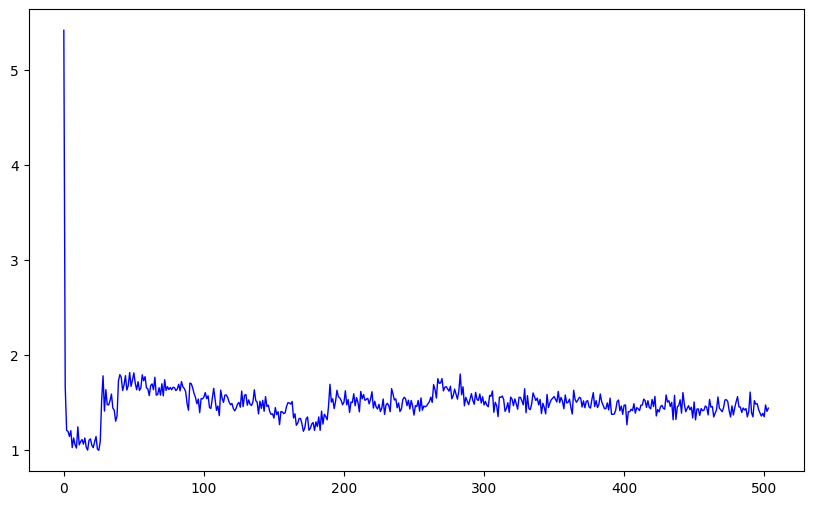

In [49]:
# Create the figure and axis
plt.figure(figsize=(10, 6))
plt.plot(steps_mod, loss_mod, 'b-', linewidth=1)

### Plotting the embeddings

In [37]:
from sklearn.decomposition import PCA
import numpy as np

In [38]:
"""Fit PCA on the initial GloVe embedding space to preserve scale."""
pca = PCA(n_components=2)  # Reduce to 2D
pca.fit(glove_embeddings)  # Fit PCA on the full Glo

PCA(n_components=2)

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [40]:
tracked_steps = list(embedding_tracker.keys())

In [41]:
len(tracked_steps)

148

/tmp/ipykernel_1911/2561273544.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(word_trajectory[:, 0], word_trajectory[:, 1], c=color_map, cmap="viridis", label=word)
/tmp/ipykernel_1911/2561273544.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(word_trajectory[:, 0], word_trajectory[:, 1], c=color_map, cmap="viridis", label=word)


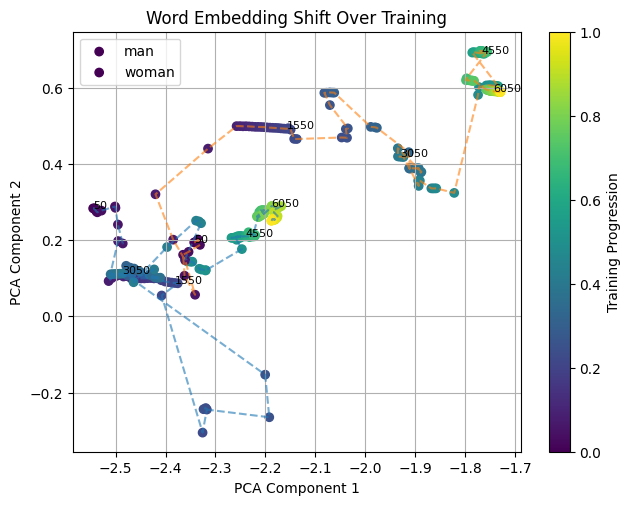

In [51]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([3, 3, 0.7, 0.7])
colors = cm.viridis(np.linspace(0, 1, len(tracked_steps)))

for word in ["man", "woman"]:
    word_trajectory = []  # Store 2D coordinates for this word
    color_map = []

    for i, batch_idx in enumerate(tracked_steps):
        if batch_idx in embedding_tracker and word in embedding_tracker[batch_idx]:
            embedding = embedding_tracker[batch_idx][word]  # Get embedding
            projected = pca.transform(embedding.reshape(1, -1))  # Project to 2D
            word_trajectory.append(projected[0])
            color_map.append(colors[i])

    word_trajectory = np.array(word_trajectory)
    if len(word_trajectory) > 0:
        plt.scatter(word_trajectory[:, 0], word_trajectory[:, 1], c=color_map, cmap="viridis", label=word)
        plt.plot(word_trajectory[:, 0], word_trajectory[:, 1], linestyle="dashed", alpha=0.6)

        # Add batch number annotations
        for i, (x, y) in enumerate(word_trajectory):
            if i % (len(tracked_steps) // 5 + 1) == 0:  # Show annotation for every few batches
                plt.text(x, y, f"{tracked_steps[i]}", fontsize=8, color="black")

plt.title("Word Embedding Shift Over Training")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.colorbar(cm.ScalarMappable(cmap="viridis"),ax=ax, label="Training Progression")
plt.grid()
plt.show()

#### Get cosine similarity

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
cosine_similarity_dict = {}

In [52]:
# Get the cosine similarity for the words
def get_similarity_batches(word1="man", word2="woman"):
    list_similarity = []
    list_batch = []
    for batch_idx, embedding_dict in embedding_tracker.items():
        similarity = cosine_similarity(embedding_tracker[batch_idx][word1].reshape(1,-1), embedding_tracker[batch_idx][word2].reshape(1,-1))[0][0]
        list_similarity.append(similarity)
        list_batch.append(batch_idx)
    return dict(zip(list_batch, list_similarity))

In [53]:
TRACK_WORDS

['man',
 'boy',
 'woman',
 'king',
 'queen',
 'rights',
 'human',
 'freedom',
 'table',
 'sit',
 'tiger',
 'carnivore']

In [58]:
man_woman_sim = get_similarity_batches("man","woman")
man_boy_sim = get_similarity_batches("man","boy")
king_queen_sim = get_similarity_batches("king", "queen")
rights_freedom_sim = get_similarity_batches("rights","freedom")
rights_human_sim = get_similarity_batches("rights","human")

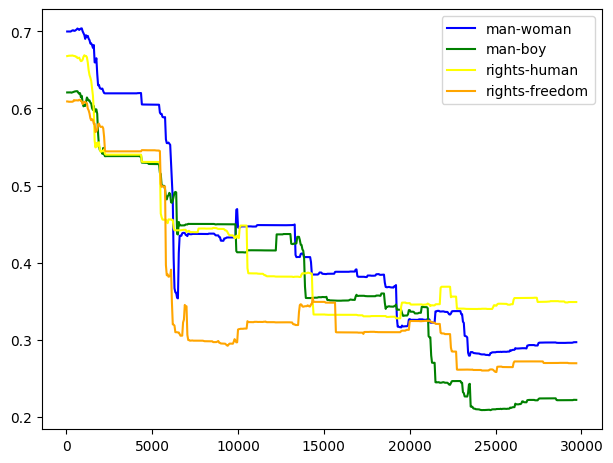

In [60]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([3, 3, 0.7, 0.7])

ax.plot(man_woman_sim.keys(), man_woman_sim.values(), label="man-woman", color="blue")
ax.plot(man_boy_sim.keys(), man_boy_sim.values(), label="man-boy", color="green")
ax.plot(rights_human_sim.keys(), rights_human_sim.values(), label="rights-human", color="yellow")
ax.plot(rights_freedom_sim.keys(), rights_freedom_sim.values(), label="rights-freedom", color="orange")
# ax.plot(king_queen_sim.keys(), king_queen_sim.values(), label="king-queen", color="red")

# Add legend
ax.legend()

# Show the plot
plt.show()